#1. alpha와 beta
- 개별 주식이나 포트폴리오의 위험을 나타내는 상대적인 지표
- 시장 리스크 등 기준이 되는 지표와의 상대적 변동성의 비율
- CAPM(자본자산가격결정모형)에서 개별자산과 포트폴리오의 위험을 측정

 - Alpha: 주식 투자의 초과 수익률, 기대 수익률과 기준 지수의 예상 수익률 간 차이. alpha>0: 시장 평균보다 초과 수익
 - Beta: 주식 또는 포트폴리오의 변동성이 시장 변동성과 연관 정도 측정. beta가 1에 가까우면 시장과의 상관관계가 높고, 1보다 작으면 시장보다 변동성이 낮으며, 1보다 크면 시장보다 변동성이 높음

In [ ]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

In [ ]:
risky_asset = 'AMZN'
market_benchmark = '^GSPC'  #S&P500
start_date = '2022-01-01'
end_date = '2023-12-31'

In [ ]:
df = yf.download( [risky_asset, market_benchmark], start=start_date, end = end_date, progress=False)

In [ ]:
X = df['Adj Close'].rename(columns={risky_asset: 'asset', market_benchmark: 'market'}).resample('M').last().pct_change().dropna()
X

Ticker,asset,market
Date,,
2022-02-28,0.026673,-0.031360
2022-03-31,0.061437,0.035773
2022-04-30,-0.237525,-0.087957
2022-05-31,-0.032764,0.000053
2022-06-30,-0.116459,-0.083920
2022-07-31,0.270596,0.091116
2022-08-31,-0.060615,-0.042440
2022-09-30,-0.108622,-0.093396
2022-10-31,-0.093451,0.079863


In [ ]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X['market'].var()
beta = covariance / benchmark_variance
beta

1.4487845995278597

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X[['market']], X['asset'])
model.coef_[0]

1.4487845995278594

#2. 포트폴리오
* 포트폴리오 최적화: 투자자 목표 수익율과 위험 선호도에 따라 가장 적합한 자산 배분 탐색

* 포트폴리오란? 투자자가 보유한 주식과 채권 등 여러 투자자산으로 이루어진 그룹

* 현대 포트폴리오 이론(Modern Portfolio Theory)
 - 해리 마코위츠, 상관관계가 낮은 여러 자산을 섞어서 분산투자
 - 동일한 수익율에서 위험을 낮출 수 있음
 - 위험은 낮추고 기대 수익율은 높은 포트폴리오 추구
 - High Risk High Return을 극복
 - 위험 대비 기대수익율이 높은 조합을 발견
 - 분산 투자의 중요성

* 포트폴리오의 체계적, 비체계적 위험
 - 시장위험 = 체계적 위험
 - 개별 자산 위험 = 비체계적 위험
 - 잘 분산된 PF는 비체계적 위험이 0에 가깝게 설정하여 최소화

* 라이브러리: PyPortfolioOpt

In [7]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
ticker_names = {
    '^KS11': 'KOSPI',
    '^KQ11': 'KOSDAQ',
    '348210.KQ': '넥스틴',
    '058610.KQ': '에스피지',
    '114840.KQ': '아이패밀리에스씨',
    '007660.KS': '이수페타시스',
    '272210.KS': '한화시스템',
    '093320.KQ': '케이아이엔엑스',
    '003230.KS': '삼양식품',
    '024110.KS': '기업은행',
    '347890.KQ': '엠투아이',
    '119610.KQ': '인터로조',
    '215000.KQ': '골프존',
    '336260.KS': '두산퓨얼셀',
    '005300.KS': '롯데칠성',
    '281740.KQ': '레이크머티리얼즈',
    '253450.KQ': '스튜디오드래곤',
    '213420.KQ': '덕산네오룩스',
    '006890.KS': '태경케미컬',
    '060720.KQ': 'KH바텍',
    '190510.KQ': '나무가',
    '002310.KS': '아세아제지',
    '013310.KQ': '아진산업',
    '003720.KS': '삼영',
    '025320.KQ': '시노펙스',
    '383310.KQ': '에코프로에이치엔',
    '145720.KS': '덴티움',
    '337930.KQ': '브랜드엑스코퍼레이션',
    '393890.KQ': '더블유씨피',
    '074600.KQ': '원익QnC',
    '251970.KQ': '펌텍코리아',
    '166090.KQ': '하나머티리얼즈',
    '036890.KQ': '진성티이씨',
    '089850.KQ': '유비벨록스',
    '403870.KQ': 'HPSP',
    '104540.KQ': '코렌텍',
    '047810.KS': '한국항공우주',
    '183300.KQ': '코미코',
    '298050.KS': '효성첨단소재',
    '214150.KQ': '클래시스',
    '086670.KQ': '비엠티',
    '078350.KQ': '한양디지텍',
    '307950.KS': '현대오토에버',
    '332370.KQ': '아이디피',
    '192820.KS': '코스맥스',
    '259960.KS': '크래프톤',
}
tickers = list(ticker_names.keys())

In [ ]:
df = yf.download(tickers)
prices = df["Adj Close"].dropna(how="all")
prices.rename(columns=ticker_names, inplace=True)

[*********************100%%**********************]  46 of 46 completed


#3. 자본자산 가격결정(CAPM: Capital Asset Pricing Model)
 - 개별 종목의 기대수익율: 시장 전체 수익율의 흐름에 영향
 - 위험 자산 기대 수익율 = 무위험자산 수익율 + b X Risk Premium
 - Risk Premium: 시장 수익율 = 무위험자산 수익율
 - beta: 위험자산 민감도, 특정 자산의 체계적 위험 측정 지표
 - beta = 시장 수익율과 위험자산 수익율의 공분산 /  위험자산 수익율의 분산
 - ols로 추정
 - 개별 종목 기대수익율은 개별 종목 위험에 비례
 - 베타: 개별 종목의 기대수익율 추정

In [ ]:
!unzip malgun.zip

Archive:  malgun.zip
  inflating: malgun.ttf              


In [ ]:
import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리

fe = fm.FontEntry(fname=r'malgun.ttf', name='malgun') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'malgun'}) #폰트설정

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 [Text(0, 0, '아세아제지'),
  Text(1, 0, '삼양식품'),
  Text(2, 0, '삼영'),
  Text(3, 0, '롯데칠성'),
  Text(4, 0, '태경케미컬'),
  Text(5, 0, '이수페타시스'),
  Text(6, 0, '아진산업'),
  Text(7, 0, '기업은행'),
  Text(8, 0, '시노펙스'),
  Text(9, 0, '진성티이씨'),
  Text(10, 0, '한국항공우주'),
  Text(11, 0, '에스피지'),
  Text(12, 0, 'KH바텍'),
  Text(13, 0, '원익QnC'),
  Text(14, 0, '한양디지텍'),
  Text(15, 0, '비엠티'),
  Text(16, 0, '유비벨록스'),
  Text(17, 0, '케이아이엔엑스'),
  Text(18, 0, '코렌텍'),
  Text(19, 0, '아이패밀리에스씨'),
  Text(20, 0, '인터로조'),
  Text(21, 0, '덴티움'),
  Text(22, 0, '하나머티리얼즈'),
  Text(23, 0, '코미코'),
  Text(24, 0, '나무가'),
  Text(25, 0, '코스맥스'),
  Text(26, 0, '덕산네오룩스'),
  Text(27, 0, '클래시스'),
  Text(28, 0, '골프존'),
  Text(29, 0, '펌텍코리아'),
  Text(30, 0, '스튜디오드래곤'),
  Text(31, 0, '크래프톤'),
  Text(32, 0, '한화시스템'),
  Text(33, 0, '레이크머티리얼

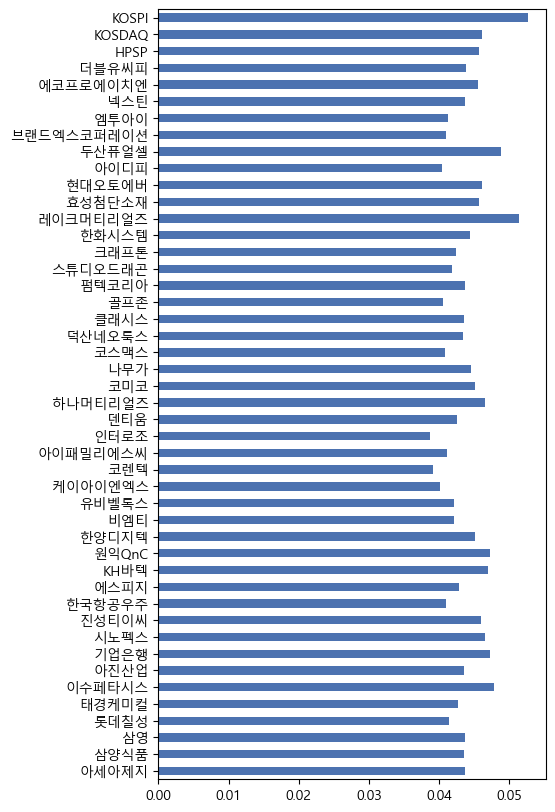

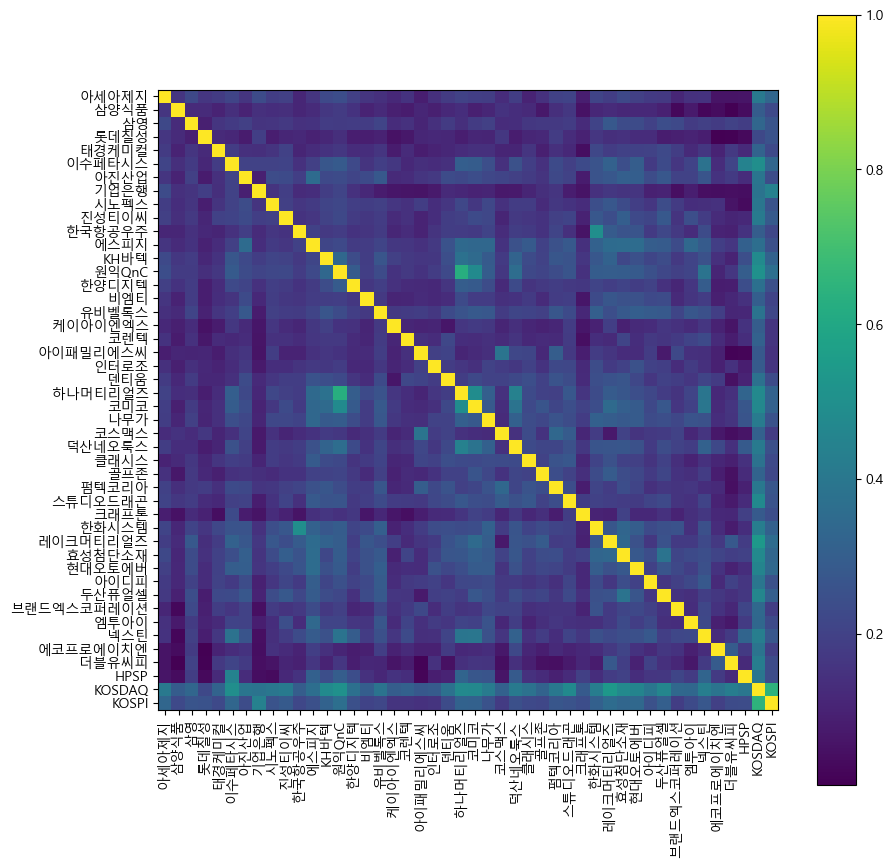

In [ ]:
from pypfopt import expected_returns

risk_free_rate= 0.035	#한국무위험지표금리의 1년 평균 사용, 3.5%
mu = expected_returns.capm_return(prices, market_prices=prices['KOSPI'].to_frame(), risk_free_rate=risk_free_rate, frequency=252)	#1년 지정
mu.plot.barh(figsize=(5, 10))

#각 자산간 상관관계
import matplotlib.pyplot as plt
import numpy as np
from pypfopt import risk_models
from pypfopt import plotting

S = risk_models.sample_cov(prices, frequency=252)

# Plot the correlation matrix
matrix = risk_models.cov_to_corr(S)
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(matrix)
fig.colorbar(cax)
ax.set_xticks(np.arange(0, matrix.shape[0], 1))
ax.set_xticklabels(matrix.index)
ax.set_yticks(np.arange(0, matrix.shape[0], 1))
ax.set_yticklabels(matrix.index)
plt.xticks(rotation=90)

#4. Efficient Frontier
- 투자 대상 중 가장 적절한 수익율과 위험을 가진 종목을 이은 곡선
- 효율적 포트폴리오: 주어진 위험 수준 대비 가장 높은 수익률을 제공하는 포트폴리오
- MPT에서의 위험: 수익률의 변동성( 과거 수익률의 표준편차)
- 동일한 기대 수익률 내에서 가장 작은 위험을 가진 포트폴리오의 집합
- 개별 종목의 기대수익률은 개별 종목의 위험에 비례하며 커지며, 특히 기대수익률 대비 위험이 큰 종목도 있고 낮은 종목도 있음
- 효율적 프론티어란 동일한 위험에서 가장 높은 수익률을 기대할 수 있는 종목들을 선으로 이은 것


Expected annual return: 4.5%
Annual volatility: 20.3%
Sharpe Ratio: 0.05


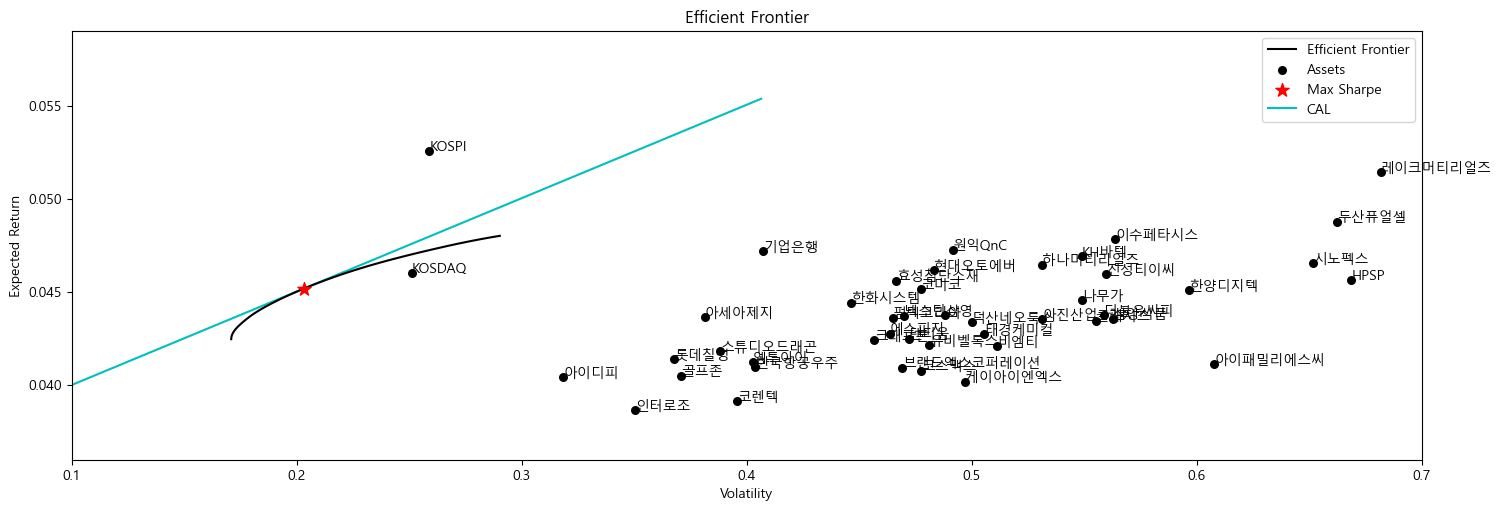

In [ ]:
import matplotlib.pyplot as plt
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

fig, ax = plt.subplots(figsize=(15, 5))
ef = EfficientFrontier(mu, S)

for name in list(ticker_names.values()):
    if name != 'KOSPI' and name != 'KOSDAQ':
        ef.add_constraint(lambda w: w[ef.tickers.index(name)] <= 0.1) # 개별종목 비중 10% 안 넘게

# Plot efficient frontier
plotting.plot_efficient_frontier(ef.deepcopy(), ax=ax, show_tickers=True)
ax.get_lines()[0].set_color("black")

# Plot the tangency portfolio
ef.max_sharpe(risk_free_rate)
weights = ef.clean_weights()
ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
ax.scatter(std_tangent, ret_tangent, s=100, c="r", marker="*", label="Max Sharpe", zorder=10)

# Plot capital allocation line
ax.plot([0, std_tangent, std_tangent*2], [risk_free_rate, ret_tangent, 2*ret_tangent-risk_free_rate], 'c', label='CAL', zorder=-1)

# Format
ax.set_title("Efficient Frontier")
ax.set_ylabel('Expected Return')
ax.set_xlim(0.1, 0.7)
ax.set_ylim(0.036, 0.059)
handles, labels = ax.get_legend_handles_labels()
labels[0], labels[1] = ['Efficient Frontier', 'Assets']
ax.legend(handles, labels)
plt.show()



 - 포트폴리오에서는 단일 종목의 비중이 너무 크지 않도록 제한: 예, 10%
 - 효율적 프론티어 우측: 코스피 지수, 코스닥은 코스피보다 위험은 크고 기대 수익률은 낮음

<Axes: xlabel='Weight'>

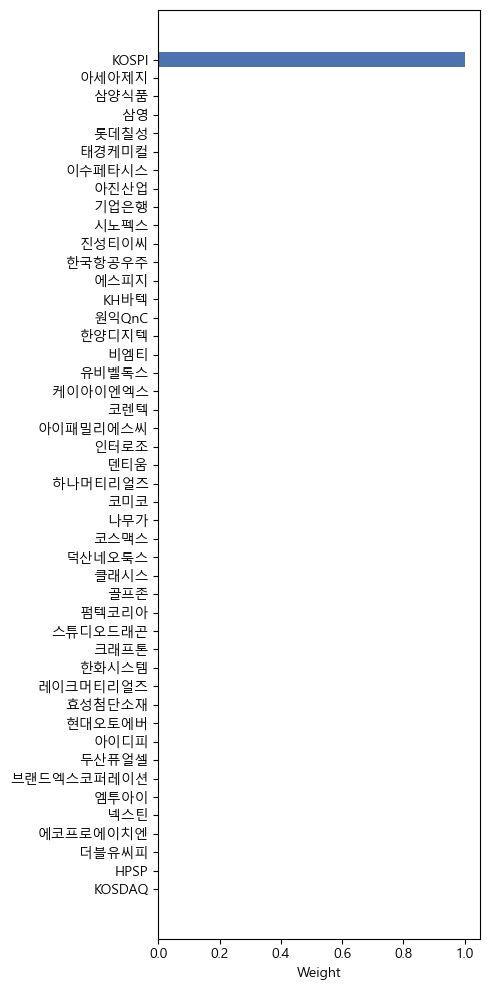

In [ ]:
fig, ax = plt.subplots(figsize=(5, 10))
plotting.plot_weights(weights, ax=ax)

- 포트폴리오 자산 배분: 코스피를 98% 이상 포함
- CAL: 효율적 프론티어 곡선에 접하는 직선,자본배분선
- MPT에서 도출된 위험자산만으로 구성된 효율적 포트폴리오에 무위험자산을 포함, 낮은 위험과 높은 기대수익률의 포트폴리오 집합, 이를 자본배분선으로 지칭

- 자본배분선의 y 절편: 무위험자산을 100% 보유하는 포트폴리오, 기대 수익률은 무위험수익률과 동일
- 자본배분선과 효율적 프론티어 곡선이 접하는 지점: 위험자산만을 보유했을 때 가장 효율적인 포트폴리오
 - 자본배분선과 효율적 프론티어 곡선이 접하는 지점이 샤프 비율이 최대가 되는 포트폴리오

- 샤프 비율(Sharpe Ratio): 해리 마코위츠의 제자 윌리엄 샤프가 개발한 투자 성과 판단용 지표
 - 총위험(total risk)에 집중하는 위험 대 보상 비율(Reward-to-risk Ratio)

    Sharpe = (Rp-Rf) / Sigmap

 - 높은 샤프 비율을 기록하는 투자일수록 더 적은 위험으로 더 높은 수익률을 내고자 함
 - 샤프 비율이 0 이하라면 시장수익률보다 낮은 수익률 의미: 샤프 비율이 0 이상이어야 투자의 고려 대상, 1 이상이면 상당히 괜찮은 투자처

#5. 효율적 시장 가설(EMH; Efficient Market Hypothesis)
- 효율적 시장 가설: 가격은 상품에 대해 얻을 수 있는 모든 정보를 빠르게 반영, 투자자는 장기적으로 시장 수익률을 넘을 수 없음

- 예를 들어, 개별주와 시장 지수(Market Index)를 포함하는 포트폴리오를 최적화, 코스피가 효율적 프론티어 위에 위치하며, 포트폴리오에 코스피를 98% 이상 배분 하라는 결과

- 해석: 코스피 100%를 보유하는 것도 매우 효율적인 포트폴리오일 수 있고, 2%의 개별주를 넣으라는 것은 오히려 단기적인 오차로 인한 결과로 의심

- 한국의 주식 시장은 효율적 시장 가설을 잘 따라가는 것으로 고려, 코스피가 효율적인 포트폴리오

#6. 포트폴리오 실습

In [33]:
import yfinance as yf
ticker_names = {
    '^KS11': 'KOSPI',
    '272210.KS': '한화시스템',
    '079550.KS': 'LIG넥스원',
    '012450.KS': '한화에어로스페이스',
    '329180.KS': 'HD현대중공업',
    '042660.KS': '한화오션',
    '064350.KS': '현대로템',
    '103140.KS': '풍산',
    '047810.KS': '한국항공우주',
    '039130.KS': '하나투어',
    '004170.KS': '신세계',
    '008770.KS': '호텔신라',
    '023530.KS': '롯데쇼핑',
    '069960.KS': '현대백화점',
    '005930.KS': '삼성전자',
    '017670.KS': 'SK텔레콤',
    '030200.KS': 'KT',
    '000660.KS': 'SK하이닉스',
}
tickers = list(ticker_names.keys())

In [50]:
df = yf.download(tickers, start="2020-01-01", end="2023-12-31")
prices = df["Adj Close"].dropna(how="all")
prices.rename(columns=ticker_names, inplace=True)

[*********************100%***********************]  18 of 18 completed


In [51]:
import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리

fe = fm.FontEntry(fname=r'malgun.ttf', name='malgun') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'malgun'}) #폰트설정

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'SK하이닉스'),
  Text(1, 0, '신세계'),
  Text(2, 0, '삼성전자'),
  Text(3, 0, '호텔신라'),
  Text(4, 0, '한화에어로스페이스'),
  Text(5, 0, 'SK텔레콤'),
  Text(6, 0, '롯데쇼핑'),
  Text(7, 0, 'KT'),
  Text(8, 0, '하나투어'),
  Text(9, 0, '한화오션'),
  Text(10, 0, '한국항공우주'),
  Text(11, 0, '현대로템'),
  Text(12, 0, '현대백화점'),
  Text(13, 0, 'LIG넥스원'),
  Text(14, 0, '풍산'),
  Text(15, 0, '한화시스템'),
  Text(16, 0, 'HD현대중공업'),
  Text(17, 0, 'KOSPI')])

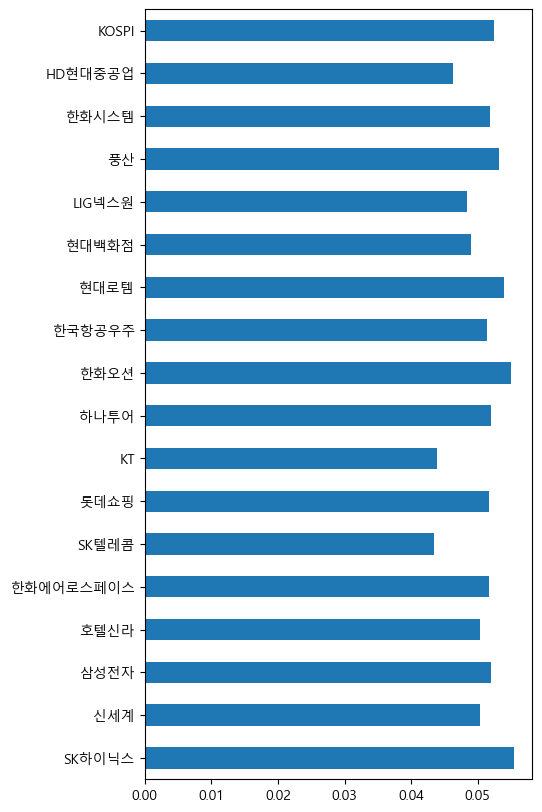

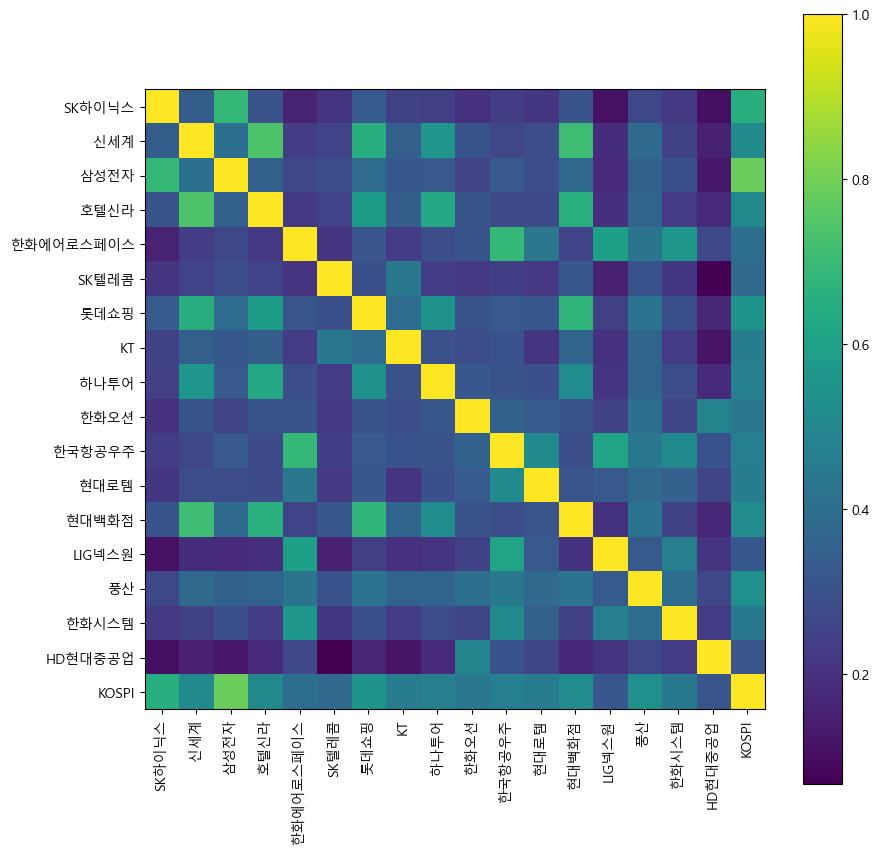

In [52]:
from pypfopt import expected_returns

risk_free_rate= 0.035	#한국무위험지표금리의 1년 평균 사용, 3.5%
mu = expected_returns.capm_return(prices, market_prices=prices['KOSPI'].to_frame(), risk_free_rate=risk_free_rate, frequency=252)	#1년 지정
mu.plot.barh(figsize=(5, 10))

#각 자산간 상관관계
import matplotlib.pyplot as plt
import numpy as np
from pypfopt import risk_models
from pypfopt import plotting

S = risk_models.sample_cov(prices, frequency=252)

# Plot the correlation matrix
matrix = risk_models.cov_to_corr(S)
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.imshow(matrix)
fig.colorbar(cax)
ax.set_xticks(np.arange(0, matrix.shape[0], 1))
ax.set_xticklabels(matrix.index)
ax.set_yticks(np.arange(0, matrix.shape[0], 1))
ax.set_yticklabels(matrix.index)
plt.xticks(rotation=90)

Expected annual return: 5.2%
Annual volatility: 20.4%
Sharpe Ratio: 0.09


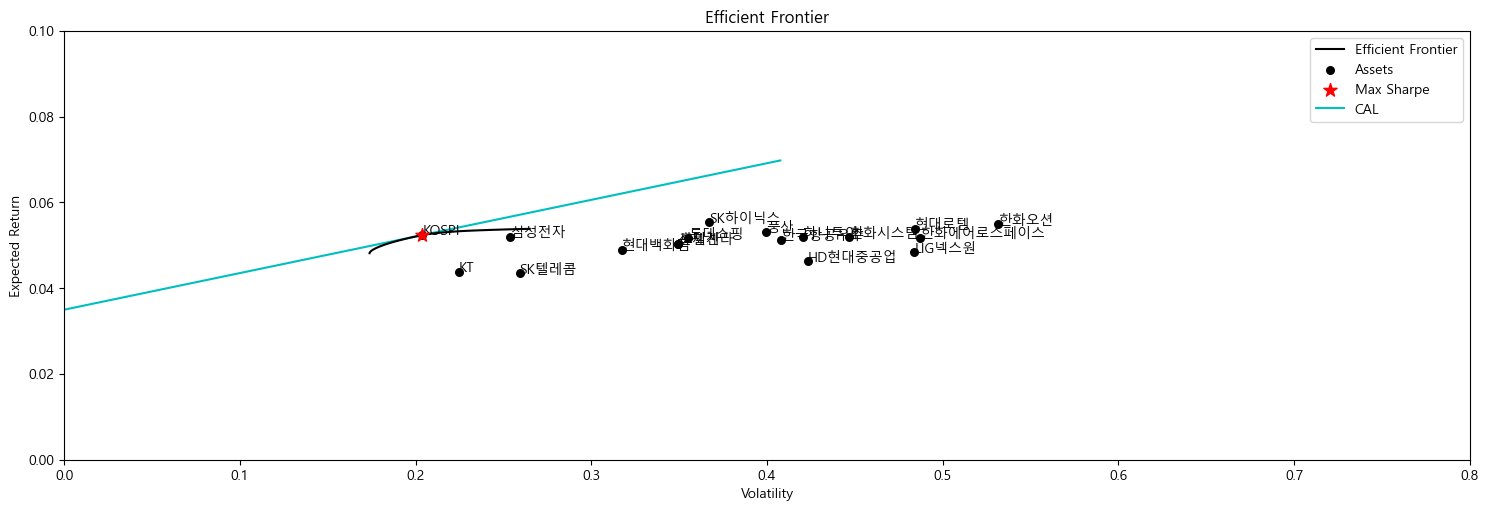

In [62]:
import matplotlib.pyplot as plt
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

fig, ax = plt.subplots(figsize=(15, 5))
ef = EfficientFrontier(mu, S)

for name in list(ticker_names.values()):
    if name != 'KOSPI' and name != 'KOSDAQ':
        ef.add_constraint(lambda w: w[ef.tickers.index(name)] <= 0.2) # 개별종목 비중 20% 안 넘게

# Plot efficient frontier
plotting.plot_efficient_frontier(ef.deepcopy(), ax=ax, show_tickers=True)
ax.get_lines()[0].set_color("black")

# Plot the tangency portfolio
ef.max_sharpe(risk_free_rate)
weights = ef.clean_weights()
ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
ax.scatter(std_tangent, ret_tangent, s=100, c="r", marker="*", label="Max Sharpe", zorder=10)

# Plot capital allocation line
ax.plot([0, std_tangent, std_tangent*2], [risk_free_rate, ret_tangent, 2*ret_tangent-risk_free_rate], 'c', label='CAL', zorder=-1)

# Format
ax.set_title("Efficient Frontier")
ax.set_ylabel('Expected Return')
ax.set_xlim(0, 0.8)
ax.set_ylim(0, 0.1)
handles, labels = ax.get_legend_handles_labels()
labels[0], labels[1] = ['Efficient Frontier', 'Assets']
ax.legend(handles, labels)
plt.show()



<Axes: xlabel='Weight'>

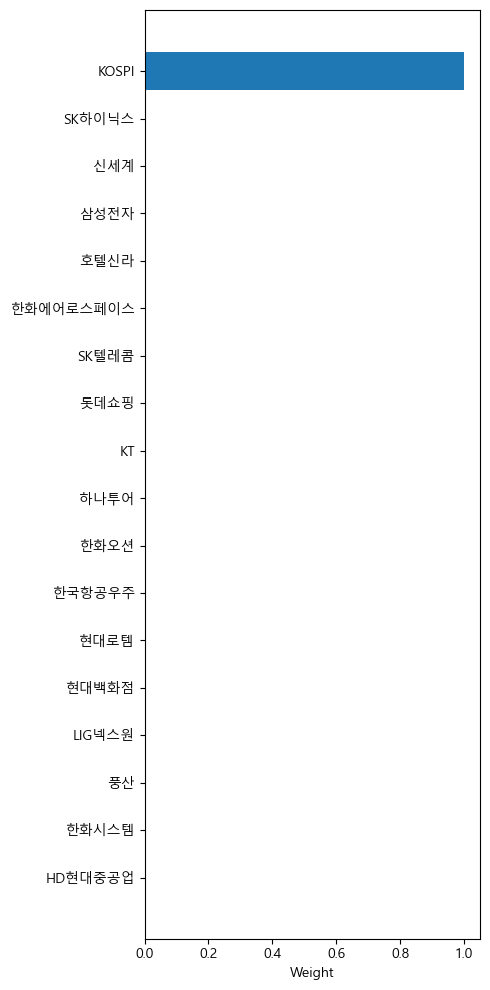

In [63]:
fig, ax = plt.subplots(figsize=(5, 10))
plotting.plot_weights(weights, ax=ax)